In [1]:
import pandas as pd

# Specify the absolute file path
file_path = "C:/Users/WELCOME/Desktop/WORK/_SUBJECT/_ĐATN/Dataset/release_validate_patients/release_validate_patients.csv"

# Read the CSV file with utf-8-sig encoding
df = pd.read_csv(file_path, encoding="utf-8-sig")

print(df.head(50))

df.columns.tolist()

df.info()

    AGE                             DIFFERENTIAL_DIAGNOSIS SEX  \
0    55  [['Anemia', 0.25071110167158567], ['Atrial fib...   F   
1    10  [['Guillain-Barré syndrome', 0.135558991316712...   F   
2    68  [['Influenza', 0.1900250899717378], ['Viral ph...   F   
3    13  [['Anemia', 0.18697604010451876], ['Atrial fib...   M   
4    48                               [['Boerhaave', 1.0]]   M   
5    55  [['Bronchitis', 0.11882160950905453], ['Pulmon...   M   
6    10                      [['Allergic sinusitis', 1.0]]   M   
7    48  [['Bronchitis', 0.5558268909318846], ['Acute o...   M   
8    48  [['Pulmonary embolism', 0.09625498420218512], ...   M   
9    96  [['Viral pharyngitis', 0.5232406274878201], ['...   M   
10   52  [['Myasthenia gravis', 0.19746239234796867], [...   M   
11   43  [['Bronchitis', 0.1068652429670829], ['Bronchi...   F   
12   56  [['Possible NSTEMI / STEMI', 0.319205660866552...   F   
13   16  [['Bronchitis', 0.1376611162498479], ['Pneumon...   M   
14   18  [

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Import XGBoost
from xgboost import XGBClassifier

# -------------------------------
# 1. LOAD THE DATA
# -------------------------------
df = pd.read_csv("release_validate_patients.csv", encoding="utf-8-sig")
print("First 5 rows of the raw data:")
print(df.head(5))

# -------------------------------
# 2. FILTER OUT NON-PATIENT RECORDS
# -------------------------------
# Convert AGE to numeric and drop rows where conversion fails.
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df = df.dropna(subset=['AGE'])
df['AGE'] = df['AGE'].astype(int)

# -------------------------------
# 3. PARSE THE DIFFERENTIAL_DIAGNOSIS COLUMN
# -------------------------------
# The column stores a string representation of a list-of-lists.
# We use ast.literal_eval to parse the string, then extract the first diagnosis.
def extract_top_diagnosis(diff_diag_str):
    try:
        diff_diag_list = ast.literal_eval(diff_diag_str)
        if isinstance(diff_diag_list, list) and len(diff_diag_list) > 0:
            # Assume the first element is the most likely diagnosis
            return diff_diag_list[0][0]
        else:
            return np.nan
    except Exception:
        return np.nan

df['top_diff_diag'] = df['DIFFERENTIAL_DIAGNOSIS'].apply(extract_top_diagnosis)
df = df.dropna(subset=['top_diff_diag'])

# -------------------------------
# 4. SPECIFY THE TARGET COLUMN & DEFINE FEATURES
# -------------------------------
# In this dataset, we assume the true diagnosis is given in PATHOLOGY.
target_col = 'PATHOLOGY'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in the DataFrame.")

print("Using target column:", target_col)

# Define the features. We are using AGE, SEX, and the extracted top differential diagnosis.
features = ['AGE', 'SEX', 'top_diff_diag']
X = df[features]
y = df[target_col]

# -------------------------------
# 5. REMOVE DUPLICATE ROWS
# -------------------------------
print(f"Number of duplicate rows before removal: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Dataset size after duplicate removal: {len(df)}")

# Reassign X and y after duplicate removal
X = df[features]
y = df[target_col]

# -------------------------------
# 6. ENCODE CATEGORICAL FEATURES
# -------------------------------
# Encode SEX and the extracted top differential diagnosis.
le_sex = LabelEncoder()
X['SEX'] = le_sex.fit_transform(X['SEX'])

le_top_diff = LabelEncoder()
X['top_diff_diag'] = le_top_diff.fit_transform(X['top_diff_diag'])

# Encode the target labels (PATHOLOGY)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# -------------------------------
# 7. SPLIT THE DATA (STRATIFIED)
# -------------------------------
# Split into training (80%) and test (20%), then split the training into training and validation.
train_X, test_X, train_y, test_y = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, test_size=0.25, random_state=42, stratify=train_y)

print(f"Training set size: {len(train_X)}")
print(f"Validation set size: {len(val_X)}")
print(f"Test set size: {len(test_X)}")

# -------------------------------
# 8. MODEL TRAINING & EVALUATION
# -------------------------------
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "XGBoost": XGBClassifier(
        objective='multi:softmax',  # for multi-class classification
        num_class=len(np.unique(y_encoded)),
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    )
}

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    model.fit(train_X, train_y)
    
    # Evaluate on the validation set
    val_predictions = model.predict(val_X)
    val_accuracy = accuracy_score(val_y, val_predictions)
    print(f"{model_name} Validation Accuracy: {val_accuracy:.2f}")
    
    # Evaluate on the test set
    test_predictions = model.predict(test_X)
    test_accuracy = accuracy_score(test_y, test_predictions)
    print(f"{model_name} Test Accuracy: {test_accuracy:.2f}")
    
    # Decode predictions to original labels for the classification report
    test_predictions_decoded = le_target.inverse_transform(test_predictions)
    test_y_decoded = le_target.inverse_transform(test_y)
    print(f"{model_name} Classification Report:\n"
          f"{classification_report(test_y_decoded, test_predictions_decoded)}")

# -------------------------------
# 9. CROSS-VALIDATION (STRATIFIED)
# -------------------------------
print("\n--- Cross-Validation Scores ---")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in models.items():
    scores = cross_val_score(model, X, y_encoded, cv=skf, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

# -------------------------------
# 10. FEATURE IMPORTANCE VISUALIZATION
# -------------------------------
# (Only applicable for models that provide feature importances, e.g. Random Forest and XGBoost)

# Random Forest Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_X, train_y)
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(rf_indices)), rf_importances[rf_indices], align="center")
plt.xticks(range(len(rf_indices)), [features[i] for i in rf_indices])
plt.tight_layout()
plt.show()

# XGBoost Feature Importance
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)
xgb_model.fit(train_X, train_y)
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (XGBoost)")
plt.bar(range(len(xgb_indices)), xgb_importances[xgb_indices], align="center")
plt.xticks(range(len(xgb_indices)), [features[i] for i in xgb_indices])
plt.tight_layout()
plt.show()


First 5 rows of the raw data:
   AGE                             DIFFERENTIAL_DIAGNOSIS SEX     PATHOLOGY  \
0   55  [['Anemia', 0.25071110167158567], ['Atrial fib...   F        Anemia   
1   10  [['Guillain-Barré syndrome', 0.135558991316712...   F  Panic attack   
2   68  [['Influenza', 0.1900250899717378], ['Viral ph...   F     Influenza   
3   13  [['Anemia', 0.18697604010451876], ['Atrial fib...   M        Anemia   
4   48                               [['Boerhaave', 1.0]]   M     Boerhaave   

                                           EVIDENCES INITIAL_EVIDENCE  
0  ['E_7', 'E_24', 'E_26', 'E_53', 'E_54_@_V_180'...            E_154  
1  ['E_16', 'E_29', 'E_50', 'E_53', 'E_54_@_V_182...            E_171  
2  ['E_50', 'E_53', 'E_54_@_V_183', 'E_54_@_V_198...             E_53  
3  ['E_7', 'E_24', 'E_26', 'E_53', 'E_54_@_V_180'...             E_53  
4  ['E_53', 'E_54_@_V_71', 'E_54_@_V_112', 'E_54_...             E_53  
Using target column: PATHOLOGY
Number of duplicate rows before 

C:\Users\WELCOME\AppData\Local\Temp\ipykernel_25252\3221877601.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['SEX'] = le_sex.fit_transform(X['SEX'])
C:\Users\WELCOME\AppData\Local\Temp\ipykernel_25252\3221877601.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['top_diff_diag'] = le_top_diff.fit_transform(X['top_diff_diag'])


Random Forest Validation Accuracy: 0.73
Random Forest Test Accuracy: 0.73
Random Forest Classification Report:
                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       0.48      0.45      0.47       414
                Acute dystonic reactions       0.95      0.99      0.97       656
                        Acute laryngitis       0.95      0.69      0.80       681
                      Acute otitis media       0.90      0.56      0.69       695
                   Acute pulmonary edema       0.84      0.78      0.81       500
                    Acute rhinosinusitis       0.50      0.33      0.40       373
                      Allergic sinusitis       0.99      0.75      0.85       425
                             Anaphylaxis       1.00      1.00      1.00       751
                                  Anemia       0.90      1.00      0.94      1381
                     Atrial fibrillation       0.75      0.80      0

c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classifica

Logistic Regression Validation Accuracy: 0.17
Logistic Regression Test Accuracy: 0.17
Logistic Regression Classification Report:
                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       0.01      0.00      0.01       414
                Acute dystonic reactions       0.47      0.96      0.63       656
                        Acute laryngitis       0.00      0.00      0.00       681
                      Acute otitis media       0.00      0.00      0.00       695
                   Acute pulmonary edema       0.00      0.00      0.00       500
                    Acute rhinosinusitis       0.00      0.00      0.00       373
                      Allergic sinusitis       0.00      0.00      0.00       425
                             Anaphylaxis       0.00      0.00      0.00       751
                                  Anemia       0.17      0.99      0.29      1381
                     Atrial fibrillation       0.0

In [3]:
!pip install tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


First 5 rows of the raw data:
   AGE                             DIFFERENTIAL_DIAGNOSIS SEX     PATHOLOGY  \
0   55  [['Anemia', 0.25071110167158567], ['Atrial fib...   F        Anemia   
1   10  [['Guillain-Barré syndrome', 0.135558991316712...   F  Panic attack   
2   68  [['Influenza', 0.1900250899717378], ['Viral ph...   F     Influenza   
3   13  [['Anemia', 0.18697604010451876], ['Atrial fib...   M        Anemia   
4   48                               [['Boerhaave', 1.0]]   M     Boerhaave   

                                           EVIDENCES INITIAL_EVIDENCE  
0  ['E_7', 'E_24', 'E_26', 'E_53', 'E_54_@_V_180'...            E_154  
1  ['E_16', 'E_29', 'E_50', 'E_53', 'E_54_@_V_182...            E_171  
2  ['E_50', 'E_53', 'E_54_@_V_183', 'E_54_@_V_198...             E_53  
3  ['E_7', 'E_24', 'E_26', 'E_53', 'E_54_@_V_180'...             E_53  
4  ['E_53', 'E_54_@_V_71', 'E_54_@_V_112', 'E_54_...             E_53  
Using target column: PATHOLOGY
Number of duplicate rows before 

C:\Users\WELCOME\AppData\Local\Temp\ipykernel_24148\1556395376.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['SEX'] = le_sex.fit_transform(X['SEX'])
C:\Users\WELCOME\AppData\Local\Temp\ipykernel_24148\1556395376.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['top_diff_diag'] = le_top_diff.fit_transform(X['top_diff_diag'])


Dataset size after duplicate removal: 132373
Training set size: 79423
Validation set size: 26475
Test set size: 26475


Training Models:   0%|          | 0/4 [00:00<?, ?model/s]


--- Training Random Forest ---
Random Forest Validation Accuracy: 0.73


Training Models:  25%|██▌       | 1/4 [00:06<00:20,  6.89s/model]

Random Forest Test Accuracy: 0.73
Random Forest Classification Report:
                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       0.48      0.45      0.47       414
                Acute dystonic reactions       0.95      0.99      0.97       656
                        Acute laryngitis       0.95      0.69      0.80       681
                      Acute otitis media       0.90      0.56      0.69       695
                   Acute pulmonary edema       0.84      0.78      0.81       500
                    Acute rhinosinusitis       0.50      0.33      0.40       373
                      Allergic sinusitis       0.99      0.75      0.85       425
                             Anaphylaxis       1.00      1.00      1.00       751
                                  Anemia       0.90      1.00      0.94      1381
                     Atrial fibrillation       0.75      0.80      0.77       521
                          

c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classifica

Logistic Regression Validation Accuracy: 0.17
Logistic Regression Test Accuracy: 0.17
Logistic Regression Classification Report:
                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       0.01      0.00      0.01       414
                Acute dystonic reactions       0.47      0.96      0.63       656
                        Acute laryngitis       0.00      0.00      0.00       681
                      Acute otitis media       0.00      0.00      0.00       695
                   Acute pulmonary edema       0.00      0.00      0.00       500
                    Acute rhinosinusitis       0.00      0.00      0.00       373
                      Allergic sinusitis       0.00      0.00      0.00       425
                             Anaphylaxis       0.00      0.00      0.00       751
                                  Anemia       0.17      0.99      0.29      1381
                     Atrial fibrillation       0.0

c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Support Vector Machine Test Accuracy: 0.45
Support Vector Machine Classification Report:
                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       0.04      0.01      0.02       414
                Acute dystonic reactions       0.55      0.98      0.70       656
                        Acute laryngitis       0.23      0.37      0.29       681
                      Acute otitis media       0.00      0.00      0.00       695
                   Acute pulmonary edema       0.00      0.00      0.00       500
                    Acute rhinosinusitis       0.00      0.00      0.00       373
                      Allergic sinusitis       0.86      0.01      0.03       425
                             Anaphylaxis       0.52      0.97      0.68       751
                                  Anemia       0.69      1.00      0.82      1381
                     Atrial fibrillation       0.27      0.20      0.23       521
        

Training Models: 100%|██████████| 4/4 [10:21<00:00, 155.28s/model]


XGBoost Test Accuracy: 0.74
XGBoost Classification Report:
                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       0.59      0.49      0.54       414
                Acute dystonic reactions       0.95      0.99      0.97       656
                        Acute laryngitis       0.96      0.69      0.80       681
                      Acute otitis media       0.95      0.56      0.71       695
                   Acute pulmonary edema       0.85      0.78      0.81       500
                    Acute rhinosinusitis       0.55      0.41      0.47       373
                      Allergic sinusitis       1.00      0.75      0.85       425
                             Anaphylaxis       1.00      1.00      1.00       751
                                  Anemia       0.90      1.00      0.95      1381
                     Atrial fibrillation       0.78      0.79      0.79       521
                               Boerhaa

Cross-Validating Models:  25%|██▌       | 1/4 [00:36<01:48, 36.19s/model]

Random Forest Cross-Validation Accuracy: 0.73 ± 0.00


c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Logistic Regression Cross-Validation Accuracy: 0.17 ± 0.00


Cross-Validating Models:  75%|███████▌  | 3/4 [51:15<22:16, 1336.74s/model]

Support Vector Machine Cross-Validation Accuracy: 0.46 ± 0.00


Cross-Validating Models: 100%|██████████| 4/4 [52:50<00:00, 792.60s/model] 

XGBoost Cross-Validation Accuracy: 0.74 ± 0.00


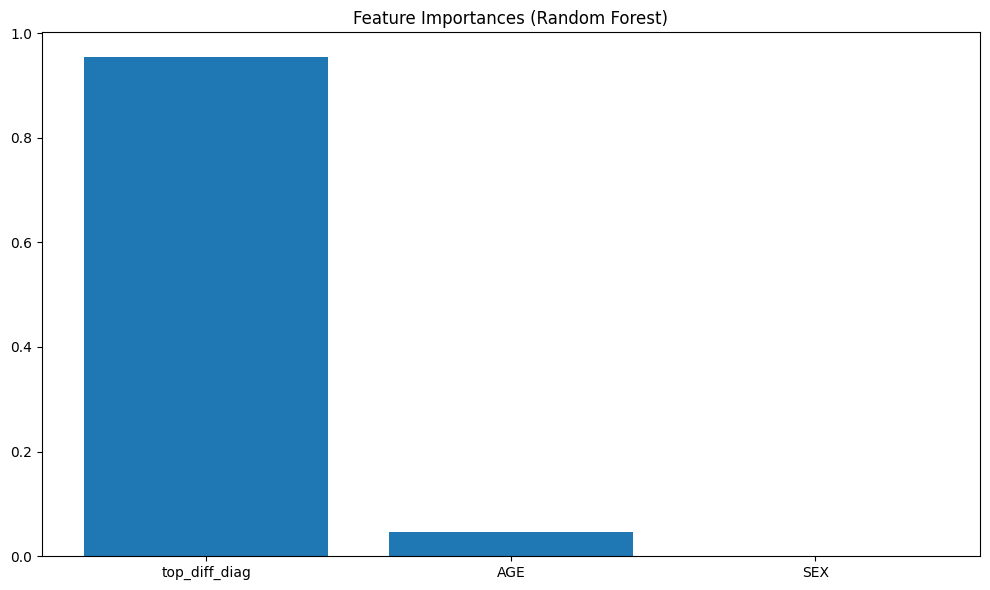

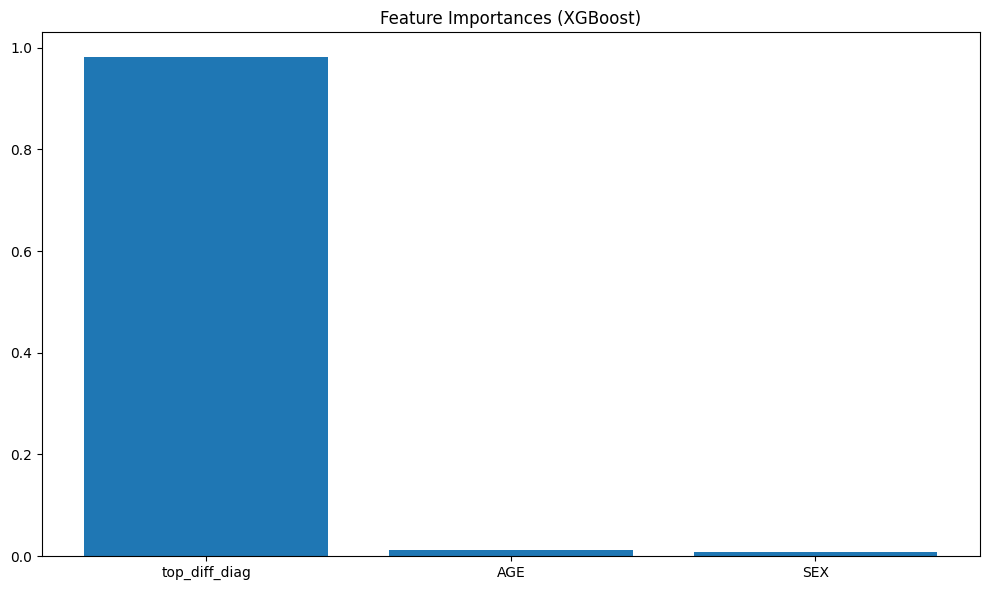

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression
from sklearn.svm import SVC  # Import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
# Import XGBoost
from xgboost import XGBClassifier
from tqdm import tqdm  # Import tqdm for progress bar

# -------------------------------
# 1. LOAD THE DATA
# -------------------------------
df = pd.read_csv("release_validate_patients.csv", encoding="utf-8-sig")
print("First 5 rows of the raw data:")
print(df.head(5))

# -------------------------------
# 2. FILTER OUT NON-PATIENT RECORDS
# -------------------------------
# Convert AGE to numeric and drop rows where conversion fails.
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df = df.dropna(subset=['AGE'])
df['AGE'] = df['AGE'].astype(int)

# -------------------------------
# 3. PARSE THE DIFFERENTIAL_DIAGNOSIS COLUMN
# -------------------------------
# The column stores a string representation of a list-of-lists.
# We use ast.literal_eval to parse the string, then extract the first diagnosis.
def extract_top_diagnosis(diff_diag_str):
    try:
        diff_diag_list = ast.literal_eval(diff_diag_str)
        if isinstance(diff_diag_list, list) and len(diff_diag_list) > 0:
            # Assume the first element is the most likely diagnosis
            return diff_diag_list[0][0]
        else:
            return np.nan
    except Exception:
        return np.nan

df['top_diff_diag'] = df['DIFFERENTIAL_DIAGNOSIS'].apply(extract_top_diagnosis)
df = df.dropna(subset=['top_diff_diag'])

# -------------------------------
# 4. SPECIFY THE TARGET COLUMN & DEFINE FEATURES
# -------------------------------
# In this dataset, we assume the true diagnosis is given in PATHOLOGY.
target_col = 'PATHOLOGY'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in the DataFrame.")
print("Using target column:", target_col)

# Define the features. We are using AGE, SEX, and the extracted top differential diagnosis.
features = ['AGE', 'SEX', 'top_diff_diag']
X = df[features]
y = df[target_col]

# -------------------------------
# 5. REMOVE DUPLICATE ROWS
# -------------------------------
print(f"Number of duplicate rows before removal: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Dataset size after duplicate removal: {len(df)}")

# Reassign X and y after duplicate removal
X = df[features]
y = df[target_col]

# -------------------------------
# 6. ENCODE CATEGORICAL FEATURES
# -------------------------------
# Encode SEX and the extracted top differential diagnosis.
le_sex = LabelEncoder()
X['SEX'] = le_sex.fit_transform(X['SEX'])
le_top_diff = LabelEncoder()
X['top_diff_diag'] = le_top_diff.fit_transform(X['top_diff_diag'])

# Encode the target labels (PATHOLOGY)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# -------------------------------
# 7. SPLIT THE DATA (STRATIFIED)
# -------------------------------
# Split into training (80%) and test (20%), then split the training into training and validation.
train_X, test_X, train_y, test_y = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, test_size=0.25, random_state=42, stratify=train_y)
print(f"Training set size: {len(train_X)}")
print(f"Validation set size: {len(val_X)}")
print(f"Test set size: {len(test_X)}")

# -------------------------------
# 8. MODEL TRAINING & EVALUATION
# -------------------------------
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "XGBoost": XGBClassifier(
        objective='multi:softmax',  # for multi-class classification
        num_class=len(np.unique(y_encoded)),
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    )
}

# Wrap the loop with tqdm to display a progress bar
for model_name, model in tqdm(models.items(), desc="Training Models", unit="model"):
    print(f"\n--- Training {model_name} ---")
    model.fit(train_X, train_y)
    
    # Evaluate on the validation set
    val_predictions = model.predict(val_X)
    val_accuracy = accuracy_score(val_y, val_predictions)
    print(f"{model_name} Validation Accuracy: {val_accuracy:.2f}")
    
    # Evaluate on the test set
    test_predictions = model.predict(test_X)
    test_accuracy = accuracy_score(test_y, test_predictions)
    print(f"{model_name} Test Accuracy: {test_accuracy:.2f}")
    
    # Decode predictions to original labels for the classification report
    test_predictions_decoded = le_target.inverse_transform(test_predictions)
    test_y_decoded = le_target.inverse_transform(test_y)
    print(f"{model_name} Classification Report:\n"
          f"{classification_report(test_y_decoded, test_predictions_decoded)}")

# -------------------------------
# 9. CROSS-VALIDATION (STRATIFIED)
# -------------------------------
print("\n--- Cross-Validation Scores ---")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Wrap the loop with tqdm for cross-validation
for model_name, model in tqdm(models.items(), desc="Cross-Validating Models", unit="model"):
    scores = cross_val_score(model, X, y_encoded, cv=skf, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

# -------------------------------
# 10. FEATURE IMPORTANCE VISUALIZATION
# -------------------------------
# Random Forest Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_X, train_y)
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(rf_indices)), rf_importances[rf_indices], align="center")
plt.xticks(range(len(rf_indices)), [features[i] for i in rf_indices])
plt.tight_layout()
plt.show()

# XGBoost Feature Importance
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)
xgb_model.fit(train_X, train_y)
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (XGBoost)")
plt.bar(range(len(xgb_indices)), xgb_importances[xgb_indices], align="center")
plt.xticks(range(len(xgb_indices)), [features[i] for i in xgb_indices])
plt.tight_layout()
plt.show()

In [3]:
!pip install cuml

  Using cached cuml-0.6.1.post1.tar.gz (1.1 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for cuml
Failed to build cuml


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [47 lines of output]
      running bdist_wheel
      running build
      C:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\setuptools\_distutils\cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
      !!
      
              ********************************************************************************
              Please avoid running ``setup.py`` directly.
              Instead, use pypa/build, pypa/installer or other
              standards-based tools.
      
              See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
              ********************************************************************************
      
      !!
        self.initialize_options()
      installing to build\bdist.win-amd64\wheel
      running install
      Traceback (most recent call last):
      

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm  # Import tqdm for progress bar

# Import XGBoost with GPU support
from xgboost import XGBClassifier

# Import cuML for GPU-accelerated models
from cuml.svm import SVC as cuSVC  # Use cuML's GPU-accelerated SVM

# -------------------------------
# 1. LOAD THE DATA
# -------------------------------
df = pd.read_csv("release_validate_patients.csv", encoding="utf-8-sig")
print("First 5 rows of the raw data:")
print(df.head(5))

# -------------------------------
# 2. FILTER OUT NON-PATIENT RECORDS
# -------------------------------
# Convert AGE to numeric and drop rows where conversion fails.
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df = df.dropna(subset=['AGE'])
df['AGE'] = df['AGE'].astype(int)

# -------------------------------
# 3. PARSE THE DIFFERENTIAL_DIAGNOSIS COLUMN
# -------------------------------
def extract_top_diagnosis(diff_diag_str):
    try:
        diff_diag_list = ast.literal_eval(diff_diag_str)
        if isinstance(diff_diag_list, list) and len(diff_diag_list) > 0:
            return diff_diag_list[0][0]
        else:
            return np.nan
    except Exception:
        return np.nan

df['top_diff_diag'] = df['DIFFERENTIAL_DIAGNOSIS'].apply(extract_top_diagnosis)
df = df.dropna(subset=['top_diff_diag'])

# -------------------------------
# 4. SPECIFY THE TARGET COLUMN & DEFINE FEATURES
# -------------------------------
target_col = 'PATHOLOGY'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in the DataFrame.")
print("Using target column:", target_col)

features = ['AGE', 'SEX', 'top_diff_diag']
X = df[features]
y = df[target_col]

# -------------------------------
# 5. REMOVE DUPLICATE ROWS
# -------------------------------
print(f"Number of duplicate rows before removal: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Dataset size after duplicate removal: {len(df)}")

X = df[features]
y = df[target_col]

# -------------------------------
# 6. ENCODE CATEGORICAL FEATURES
# -------------------------------
le_sex = LabelEncoder()
X['SEX'] = le_sex.fit_transform(X['SEX'])
le_top_diff = LabelEncoder()
X['top_diff_diag'] = le_top_diff.fit_transform(X['top_diff_diag'])

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# -------------------------------
# 7. SPLIT THE DATA (STRATIFIED)
# -------------------------------
train_X, test_X, train_y, test_y = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, test_size=0.25, random_state=42, stratify=train_y)
print(f"Training set size: {len(train_X)}")
print(f"Validation set size: {len(val_X)}")
print(f"Test set size: {len(test_X)}")

# -------------------------------
# 8. TUNE SVM WITH KERNEL TRICK
# -------------------------------
# Define the SVM model with an RBF kernel
svm_model = cuSVC(kernel='rbf', probability=True, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': [0.01, 0.1, 1]  # Kernel coefficient
}

# Wrap GridSearchCV with tqdm for progress tracking
grid_search = GridSearchCV(svm_model, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(train_X.values, train_y)

# Get the best model
best_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the best model on the validation set
val_predictions = best_svm.predict(val_X.values)
val_accuracy = accuracy_score(val_y, val_predictions)
print(f"SVM (RBF Kernel) Validation Accuracy: {val_accuracy:.2f}")

# Evaluate on the test set
test_predictions = best_svm.predict(test_X.values)
test_accuracy = accuracy_score(test_y, test_predictions)
print(f"SVM (RBF Kernel) Test Accuracy: {test_accuracy:.2f}")

# Decode predictions to original labels for the classification report
test_predictions_decoded = le_target.inverse_transform(test_predictions.astype(int))
test_y_decoded = le_target.inverse_transform(test_y)
print(f"SVM (RBF Kernel) Classification Report:\n"
      f"{classification_report(test_y_decoded, test_predictions_decoded)}")

# -------------------------------
# 9. FEATURE IMPORTANCE VISUALIZATION
# -------------------------------
# Feature importance visualization is not directly available for SVM.
# However, we can visualize the decision boundary for 2D data.
if len(features) == 2:
    from mlxtend.plotting import plot_decision_regions
    plt.figure(figsize=(10, 6))
    plot_decision_regions(train_X.values, train_y, clf=best_svm)
    plt.title("SVM Decision Boundary (RBF Kernel)")
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()

ModuleNotFoundError: No module named 'cuml'